<a href="https://colab.research.google.com/github/ajaym416/TreeleafAIchallenge/blob/main/resnet_classifier_training_for_eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import os
import time
import numpy as np
from torchvision import datasets , models
from torch.utils.data import Dataset , DataLoader
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import logging
from tqdm.notebook import tqdm
import torchvision
import torch.nn as nn

In [ ]:
!unzip /content/drive/MyDrive/Datasets/Dataset_A_Eye_Images.zip -d /content/
!unzip /content/drive/MyDrive/Datasets/mrlEyes_2018_01.zip -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05259_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05260_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05261_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05262_1_1_0_0_1_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05263_1_1_0_0_1_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05264_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05265_1_1_0_0_1_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05266_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05267_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05268_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05269_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037_05270_1_1_0_0_0_01.png  
 extracting: /content/mrlEyes_2018_01/s0037/s0037

In [ ]:
dirlist=os.listdir("/content/mrlEyes_2018_01")
image_path_list_1 =[]
for folder in dirlist:
  try:
    for images in os.listdir(os.path.join("/content/mrlEyes_2018_01",folder)):
      image_path = os.path.join("/content/mrlEyes_2018_01",folder , images)
      image_path_list_1.append(image_path)
  except Exception as e:
    print(e)


[Errno 20] Not a directory: '/content/mrlEyes_2018_01/stats_2018_01.ods'
[Errno 20] Not a directory: '/content/mrlEyes_2018_01/annotation.txt'


In [ ]:
len(image_path_list_1)

84898

In [ ]:
import glob
image_path_list_2=[x for x in glob.glob("/content/Dataset_A_Eye_Images/*/*") if os.path.split(x)[-1][-3:]=="jpg"]

In [ ]:
len(image_path_list_2)

8984

In [ ]:
image_path_list_1[0]

'/content/mrlEyes_2018_01/s0020/s0020_00526_0_0_1_0_0_01.png'

In [ ]:
image_path_list_2[0]

'/content/Dataset_A_Eye_Images/closedEyesTraining/ct0117.jpg'

In [ ]:
os.path.split(os.path.split(image_path_list_2[8000])[-2])[-1]

'openEyesTraining'

In [ ]:
os.path.split(os.path.split(image_path_list_2[0])[-2])[-1]

'closedEyesTraining'


Description of mrl eye dataset image name
subject ID:
xxx

image number:
xxx

gender:
0 - male
1 - famale

glasses:
0 - no
1 - yes

eye state:
0 - close
1 - open

reflections:
0 - none
1 - low
2 - high

lighting conditions/image quality:
0 - bad
1 - good

sensor type:
01 - RealSense SR300 640x480
02 - IDS Imaging, 1280x1024
03 - Aptina Imagin 752x480

example:
s001_00123_0_0_0_0_0_01.png


In [ ]:
train_images_path =image_path_list_1+image_path_list_2

In [ ]:
len(train_images_path)

93882

In [ ]:
import torchvision.transforms as T
def get_train_transform():
  return (T.Compose([
                     T.RandomHorizontalFlip(p=0.5),
                     T.RandomRotation(15),
                     T.RandomCrop(35,),
                     T.ToTensor(),
                     T.ColorJitter(brightness=(0.5,1.5), contrast=(0.5,1.5), saturation=(0.5,1.5), hue=(-0.1,0.1)),
                    #  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                     T.Normalize(mean=[0.3473, 0.3473, 0.3473], std=[0.0805, 0.0805, 0.0805])

                    ]))
def get_val_transform():
  return (T.Compose([T.ToTensor(),
                     ]))

In [ ]:
class EyeDataset(Dataset):
    def __init__(self,img_size = 40 ,train=True ,val_stride =10 ,sort_by_random =True,train_images =train_images_path,transforms=get_train_transform()):
        self.img_size =img_size
        self.train = train
        self.val_stride = val_stride
        self.sort_by_random= sort_by_random
        self.train_images=train_images.copy()
        self.transforms=transforms
        if self.sort_by_random:
          np.random.shuffle(self.train_images)
        if self.train:
          del self.train_images[::val_stride]
        else:
          self.train_images = self.train_images[::val_stride]
    def __len__(self):
        return len(self.train_images)
    def __getitem__(self ,idx):
        image_path = self.train_images[idx]
        img = Image.open(image_path)
        img = img.resize((self.img_size, self.img_size))
        # /content/mrlEyes_2018_01/s0021/s0021_00852_0_1_1_1_0_01.png
        # /content/Dataset_A_Eye_Images/openEyesTraining/o3205.jpg
        if os.path.split(self.train_images[idx])[-1][-3:] == "jpg":
          if (os.path.split(os.path.split(self.train_images[idx])[-2])[-1])=='openEyesTraining':
            #for open eye
            label =np.eye(2)[0]
            label = torch.tensor(label, dtype = torch.float32)
          elif (os.path.split(os.path.split(self.train_images[idx])[-2])[-1])=='closedEyesTraining':
            #for closed eye
            label =np.eye(2)[1]
            label = torch.tensor(label, dtype = torch.float32)
          else:
            print(image_path)
        elif os.path.split(self.train_images[idx])[-1][-3:] == "png":
          if (image_path[-12])=="1":
            #for open eye
            label =np.eye(2)[0]
            label = torch.tensor(label, dtype = torch.float32)
          elif (image_path[-12])=="0":
            #for closed eye
            label =np.eye(2)[1]
            label = torch.tensor(label, dtype = torch.float32)
          else:
            print(image_path)
        #converting  png images to 3d
        if np.array(img).shape[-1] !=3:
          img=np.array(img)
          rgb_image = np.repeat( img[:,:,np.newaxis], 3,-1)
          img=Image.fromarray(np.uint8(rgb_image))
                  
        img = self.transforms(img)
        return img, label


In [ ]:
train_data = EyeDataset()
val_data = EyeDataset(train=False,transforms=get_val_transform())
print(len(train_data),len(val_data))

84493 9389


In [ ]:
use_cuda =torch.cuda.is_available()
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
train_dl = torch.utils.data.DataLoader( 
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=8,
)
val_dl=torch.utils.data.DataLoader( 
    val_data,
    batch_size=32,
    shuffle=True,
    num_workers=8,
)

In [ ]:
Writer  = SummaryWriter("Output")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

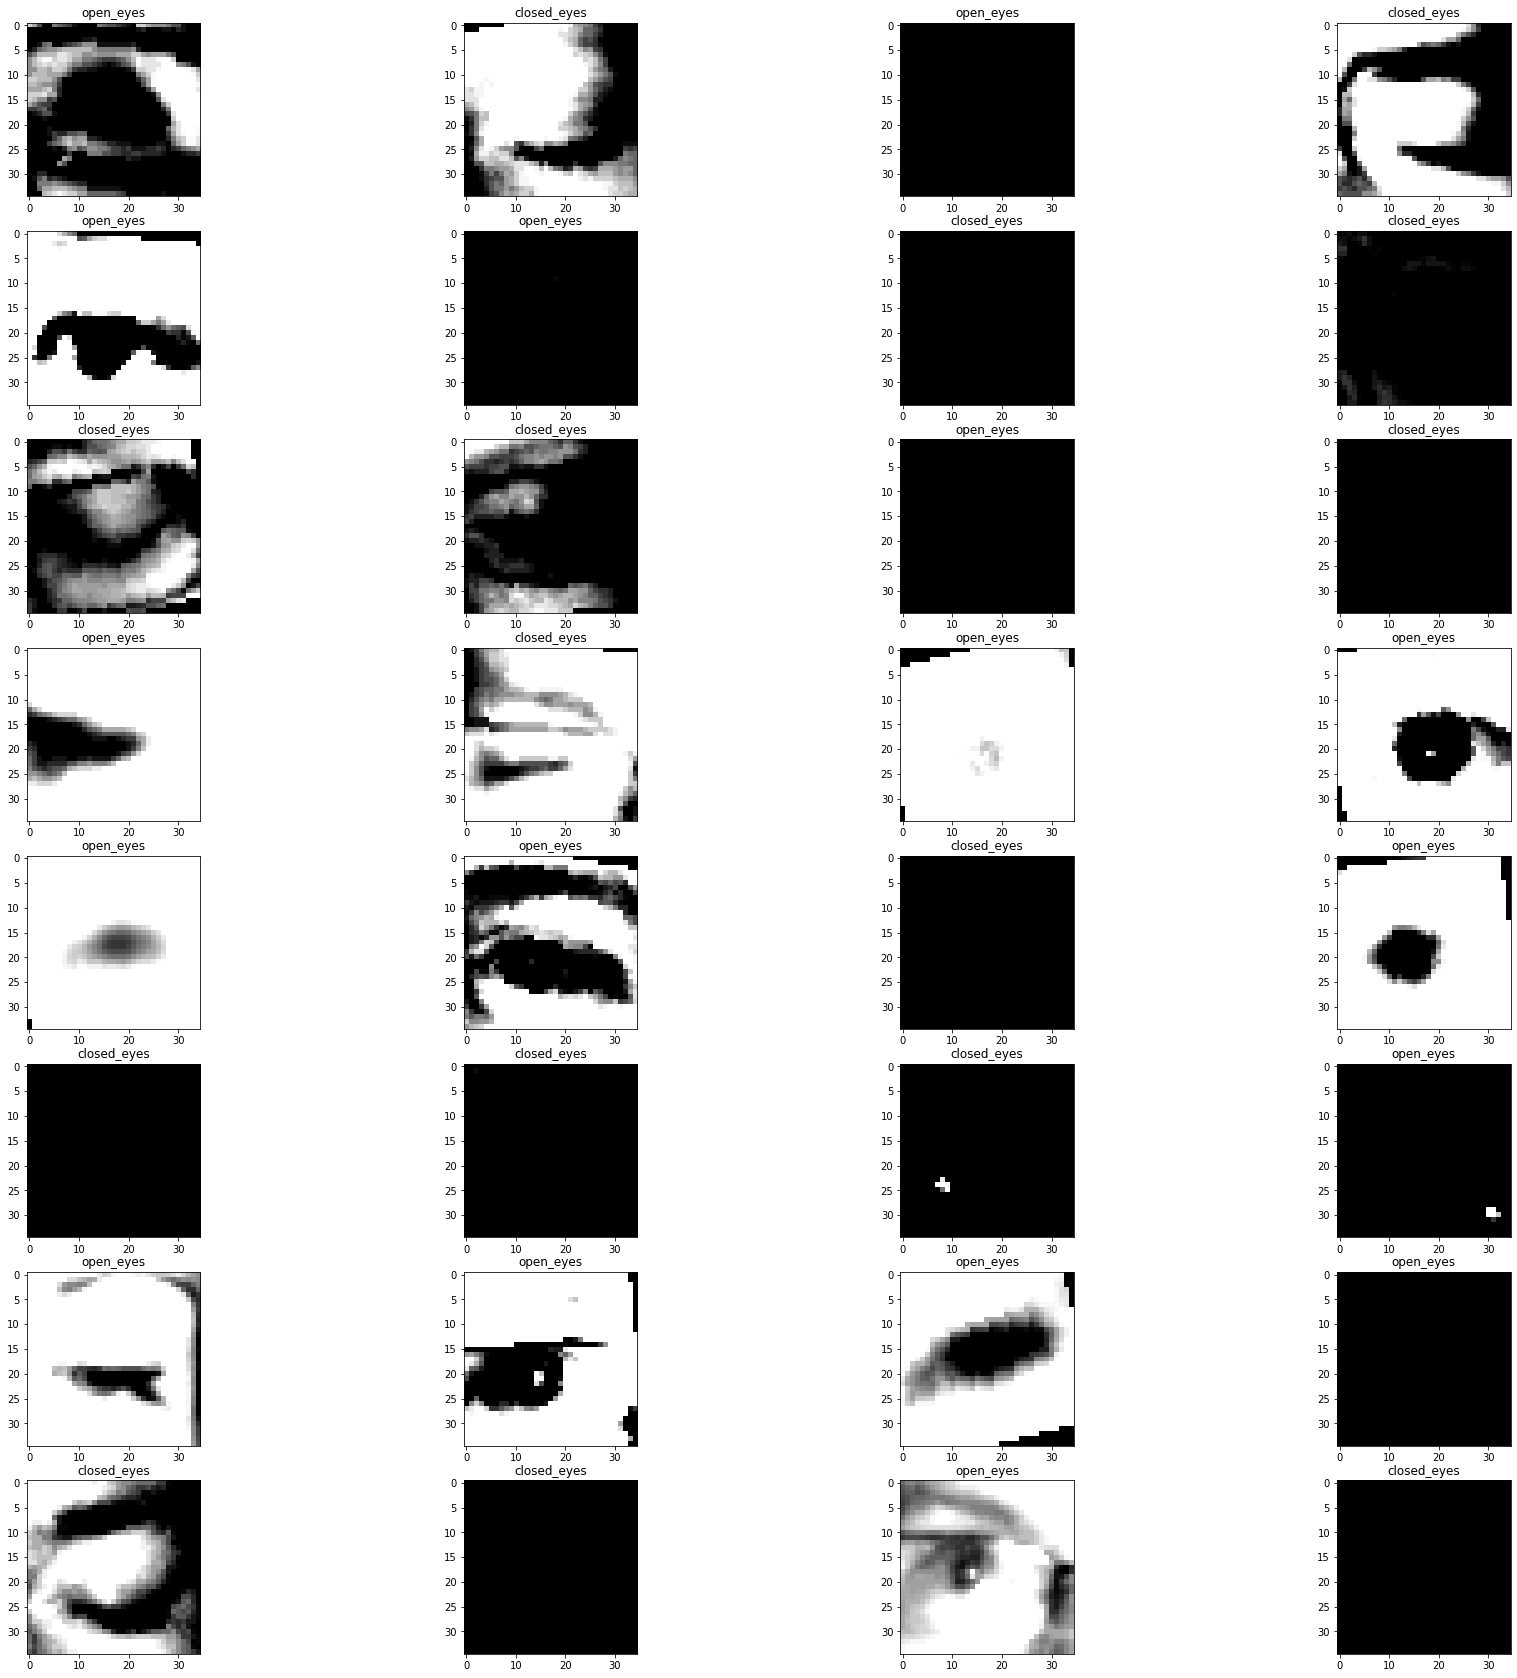

In [ ]:
fig = plt.figure(figsize=(30, 30))
columns = 4
rows = 8
images, labels = next(iter(train_dl))
# ax enables access to manipulate each of subplots
ax = []
for i in range(columns*rows):
  ax.append(fig.add_subplot(rows,columns,i+1))

for i,img in enumerate(images):
  ax[i].imshow(img.permute(1,2,0))
  if labels[i][0]==0:
    ax[i].set_title("closed_eyes")
  else:
    ax[i].set_title("open_eyes" )

plt.show()  # finally, render the plot
image_grid = torchvision.utils.make_grid(images)
Writer.add_image('Eyes',image_grid)

In [ ]:
#To get the the mean and standard deviation of our dataset
# train_data = EyeDataset()
# loader = DataLoader(
#     train_data,
#     batch_size=32,
#     num_workers=4,
#     shuffle=False
# )

# mean = 0.
# std = 0.
# nb_samples = 0.
# for data in loader:
#   data ,labels =data
#   batch_samples = data.size(0)
#   data = data.view(batch_samples, data.size(1), -1)
#   mean += data.mean(2).sum(0)
#   std += data.std(2).sum(0)
#   nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples
# print(mean)
# print(std)

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    # nn.Dropout(0.5),
    nn.Linear(512, 2),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
def Accuracy(preds, labels):
  preds =[[1 if preds[i][j]>= 0.5 else 0 for j in range(preds.shape[1])] for i in range(preds.shape[0])]
  total =len(preds)
  correct = np.sum([(preds[i]==np.array(torch.Tensor.tolist(labels)).astype(int)[i])[0] for i in range(len(labels))])
  return correct/total

In [ ]:
def train_one_epoch(train_data_loader,epoch):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for i,(images, labels) in tqdm(enumerate(train_data_loader)):
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = Accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
        Writer.add_scalar("Training Loss" ,loss,(epoch*len(train_data_loader)+i))
        Writer.add_scalar("Training Accuracy" ,acc,(epoch*len(train_data_loader)+i))

    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
    
    return epoch_loss, epoch_acc, total_time

In [ ]:
def val_one_epoch(val_data_loader,epoch, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for i,(images, labels) in enumerate(val_data_loader):
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = Accuracy(preds, labels)
        epoch_acc.append(acc)
        Writer.add_scalar("Validation Loss" ,loss,(epoch*len(val_data_loader)+i))
        Writer.add_scalar("Validation Accuracy" ,acc,(epoch*len(val_data_loader)+i))
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet18_eye_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
#Loss Function
criterion = nn.BCELoss()
# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}
# Loading model to device
model.to(device)
# No of epochs 
epochs = 7

In [ ]:
best_val_acc = 0
for epoch in range(epochs):
    ###Training
    loss, acc, _time = train_one_epoch(train_dl,epoch)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss,acc,_time,best_val_acc = val_one_epoch(val_dl,epoch, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))



Training
Epoch 1
Loss : 0.0545
Acc : 0.9804
Time : 209.5821

Validating
Epoch 1
Loss : 0.0506
Acc : 0.9802
Time : 7.2432




Training
Epoch 2
Loss : 0.0528
Acc : 0.9816
Time : 207.0276

Validating
Epoch 2
Loss : 0.0487
Acc : 0.9816
Time : 7.2175




Training
Epoch 3
Loss : 0.0491
Acc : 0.9821
Time : 207.3053

Validating
Epoch 3
Loss : 0.0547
Acc : 0.9778
Time : 7.3149




Training
Epoch 4
Loss : 0.0498
Acc : 0.9818
Time : 206.1146

Validating
Epoch 4
Loss : 0.0629
Acc : 0.9748
Time : 7.2644




Training
Epoch 5
Loss : 0.047
Acc : 0.9831
Time : 206.2784

Validating
Epoch 5
Loss : 0.054
Acc : 0.9788
Time : 7.3908




Training
Epoch 6
Loss : 0.0467
Acc : 0.9827
Time : 208.0626

Validating
Epoch 6
Loss : 0.0418
Acc : 0.9843
Time : 7.373




Training
Epoch 7
Loss : 0.0458
Acc : 0.9832
Time : 213.3685

Validating
Epoch 7
Loss : 0.0449
Acc : 0.9821
Time : 7.4429


In [ ]:
PILimage =Image.open("/content/as.png").convert('RGB')
preprocess = T.Compose([
    T.Resize(40),
    T.ToTensor(),
    T.Normalize(mean=[0.3473, 0.3473, 0.3473], std=[0.0805, 0.0805, 0.0805])
])
processed_img=preprocess(PILimage)
batch_t=torch.unsqueeze(processed_img ,0)
model.to('cpu')
with torch.no_grad():
    out =model(batch_t)
    _,pred = torch.max(out , 1)
print(out)
prediction = np.array(pred[0])
print(prediction)
if prediction == 0 :
    print("open_eye")
elif prediction== 1:
    print("closed_eye")


tensor([[0.6099, 0.3984]])
0
open_eye
